In [21]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib

In [2]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [153]:
def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
):
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    genes_to_show = lig_rec_idx.split("_")
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5))
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=20, data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        ax[i].set_xlabel("spatial1")
        ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    plt.show()


from matplotlib.colors import Normalize

def plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    dist_list_dict = None
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    g11, g12 = int_type.split('=')
    if dist_list_dict is None:
        
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        coeff = row.copula_coeff
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm(
            [coeff,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
    else:
        g11, g12 = int_name.split('=')
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        rho_zero = row.rho_zero
        rho_one = row.rho_one
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm_dist(
            [rho_zero,rho_one,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            dist_list_dict[int_name],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
        
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = plt.get_cmap('Reds')
    norm = Normalize(vmin=min(loglikvec), vmax=max(loglikvec))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    # Remove the legend and add a colorbar
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    
    for i,edge in enumerate(lr_pairs_ct[['cell1', 'cell2']].values):
        color = cmap(norm(loglikvec[i]))
        x1, y1 = loc_df.loc[  edge[0], 'x' ], loc_df.loc[  edge[0], 'y' ]
        x2, y2 = loc_df.loc[  edge[1], 'x' ], loc_df.loc[  edge[1], 'y' ]
        ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
                linestyle='-', markersize=0.5,linewidth=1)
    cbar = plt.colorbar(sm, ax=ax, label='Loglikelihood')
    #ax.get_legend().remove()
    ax.set_title(lig_rec_idx + "\n" + int_type.replace('=',' → '))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")

In [3]:
adata = sc.read_h5ad(
    'data/mosta_mouse_embryo/E9.5_E1S1.MOSTA.h5ad')

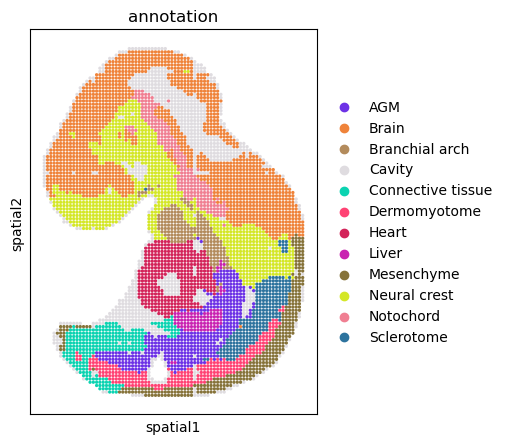

In [32]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], spot_size=1, ax =ax)

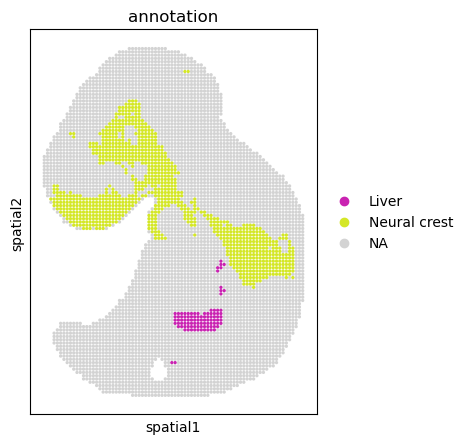

In [76]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], groups = ['Liver', 'Neural crest'],
              spot_size=1, ax =ax)

In [8]:
adata.shape

(5913, 25568)

In [7]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sdm.extract_lr(adata, 'mouse', min_cell=20)

In [10]:
adata.obs['celltype'] = adata.obs.annotation

In [11]:
adata_sdm = adata.copy()

In [19]:
adata.uns.keys()

dict_keys(['annotation_colors', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'])

In [24]:
importlib.reload(spatial)

<module 'spatial' from '/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py'>

In [31]:
adata.obs = adata.obs[['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'annotation', 'celltype']]

In [36]:
adata.var = adata.var[['n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']]

In [41]:
spatial.construct_spatial_network(adata, n_rings=2)

In [42]:
print(adata.uns['spatial_network'])

Graph with 5913 nodes and 34401 edges


In [43]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata
)

/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if (adata.obs[domanin_name].dtype.name != domanin_name):


relabeling nodes


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5913/5913 [00:00<00:00, 9912.26it/s]


In [45]:
int_edges_with_selfloop.boundary_type.value_counts()

boundary_type
Internal    23469
External    13976
Name: count, dtype: int64

In [47]:
int_edges_new.boundary_type.value_counts()

boundary_type
Internal    17556
External    13976
Name: count, dtype: int64

In [53]:
adata.layers['count'].toarray().shape

(5913, 25568)

In [54]:
adata.X = adata.layers['count']

In [55]:
adata.raw = adata.copy()

In [56]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]

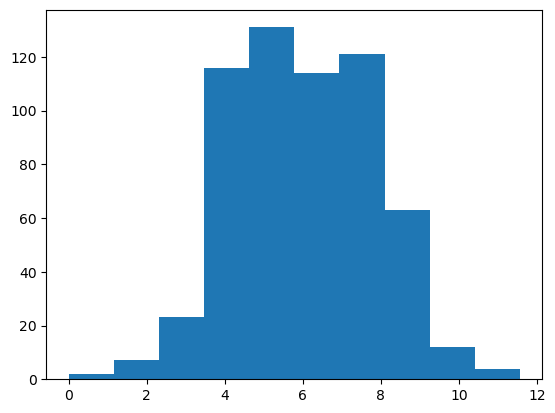

In [64]:
plt.hist(np.log(count_df.sum()));

In [65]:
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values

In [66]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

<Axes: xlabel='interaction'>

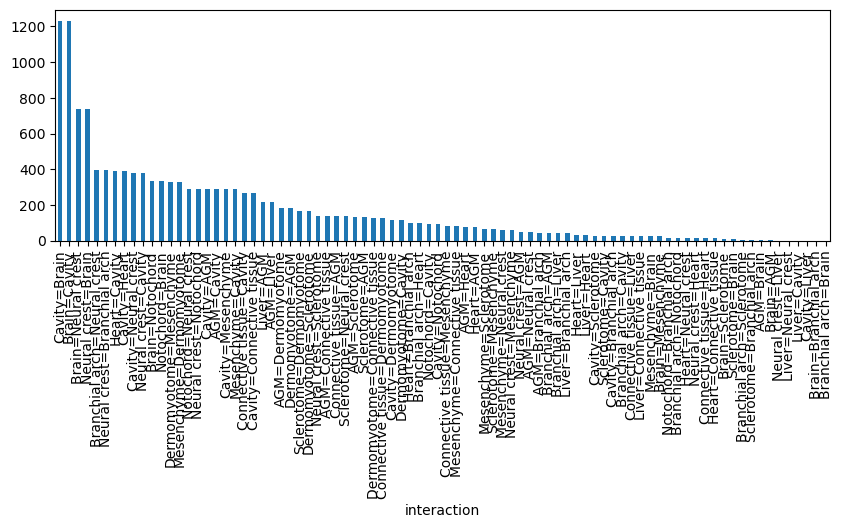

In [78]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.value_counts().plot(kind='bar',ax =ax)

In [95]:
boundary_type_subsets = int_edges_new.interaction.value_counts()[
    (int_edges_new.interaction.value_counts() > 200)
].index

In [96]:
boundary_type_subsets

Index(['Brain=Brain', 'Neural crest=Neural crest', 'Cavity=Cavity',
       'Heart=Heart', 'Cavity=Brain', 'Brain=Cavity', 'AGM=AGM',
       'Sclerotome=Sclerotome', 'Brain=Neural crest', 'Neural crest=Brain',
       'Connective tissue=Connective tissue', 'Branchial arch=Branchial arch',
       'Branchial arch=Neural crest', 'Neural crest=Branchial arch',
       'Heart=Cavity', 'Cavity=Heart', 'Neural crest=Cavity',
       'Cavity=Neural crest', 'Notochord=Brain', 'Brain=Notochord',
       'Dermomyotome=Mesenchyme', 'Mesenchyme=Dermomyotome',
       'Neural crest=Notochord', 'Notochord=Neural crest', 'Cavity=AGM',
       'AGM=Cavity', 'Mesenchyme=Cavity', 'Cavity=Mesenchyme',
       'Connective tissue=Cavity', 'Cavity=Connective tissue',
       'Notochord=Notochord', 'Mesenchyme=Mesenchyme', 'Liver=AGM',
       'AGM=Liver'],
      dtype='object', name='interaction')

In [97]:
int_edges_subset = int_edges_new.loc[
    int_edges_new.interaction.isin(boundary_type_subsets)
]

In [99]:
int_edges_subset.shape

(27636, 7)

In [100]:
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_subset,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:37<00:00,  1.11s/it]


In [101]:
cop_df = model.run_copula(
    data_list_dict,
    umi_sums,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=2,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Mesenchyme=Mesenchyme


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  war

Connective tissue=Connective tissue


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


AGM=AGM


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1261 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Sclerotome=Sclerotome


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    7.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0

Cavity=Cavity
Heart=Heart


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 1154 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   10.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Neural crest


[Parallel(n_jobs=20)]: Done 495 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done 1190 tasks      | elapsed:   13.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   18.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Branchial arch=Branchial arch


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Brain


[Parallel(n_jobs=20)]: Done 359 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 666 tasks      | elapsed:   15.7s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:   23.3s remaining:    0.7s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   30.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Notochord


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Mesenchyme


[Parallel(n_jobs=20)]: Done 724 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mesenchyme=Cavity


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mesenchyme=Dermomyotome


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Dermomyotome=Mesenchyme


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Connective tissue


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    2.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Connective tissue=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    3.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearman

Cavity=AGM
AGM=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


AGM=Liver


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Liver=AGM


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Heart
Heart=Cavity


/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Neural crest
Neural crest=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Branchial arch=Neural crest


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Branchial arch


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    4.9s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Brain


[Parallel(n_jobs=20)]: Done 520 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Neural crest


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Notochord


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Neural crest


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Brain=Cavity
Cavity=Brain


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Brain=Notochord


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Brain


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.3s finished


In [102]:
cop_df_dict = cop_df

In [104]:
cop_df_with_scc_dict = model.run_scc(
    count_df,
    None,
    cop_df_dict,
    int_edges_subset,
    groups = list(data_list_dict.keys()),
    heteronomic=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization = "sum"
)

Mesenchyme=Mesenchyme
Graph with 57 nodes and 166 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=20)]: Done 453 tasks      | elapsed:    7.4s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copula

Connective tissue=Connective tissue
Graph with 70 nodes and 347 edges


/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered i

AGM=AGM
Graph with 130 nodes and 603 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished


Sclerotome=Sclerotome
Graph with 100 nodes and 528 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished


Cavity=Cavity
Graph with 206 nodes and 1046 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.7s finished


Heart=Heart
Graph with 164 nodes and 837 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.4s finished


Neural crest=Neural crest
Graph with 409 nodes and 2251 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.7s finished


Branchial arch=Branchial arch
Graph with 59 nodes and 279 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished


Brain=Brain
Graph with 761 nodes and 4442 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    8.3s finished


Notochord=Notochord
Graph with 46 nodes and 166 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished


Cavity=Mesenchyme
DiGraph with 215 nodes and 287 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


Mesenchyme=Cavity
DiGraph with 215 nodes and 287 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


Mesenchyme=Dermomyotome
DiGraph with 224 nodes and 328 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.9s finished


Dermomyotome=Mesenchyme
DiGraph with 224 nodes and 328 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.0s finished


Cavity=Connective tissue
DiGraph with 198 nodes and 270 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


Connective tissue=Cavity
DiGraph with 198 nodes and 270 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.7s finished


Cavity=AGM
DiGraph with 205 nodes and 288 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.7s finished


AGM=Cavity
DiGraph with 205 nodes and 288 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


AGM=Liver
DiGraph with 159 nodes and 217 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.5s finished


Liver=AGM
DiGraph with 159 nodes and 217 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.5s finished


Cavity=Heart
DiGraph with 265 nodes and 392 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.3s finished


Heart=Cavity
DiGraph with 265 nodes and 392 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.2s finished


Cavity=Neural crest
DiGraph with 276 nodes and 379 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.3s finished


Neural crest=Cavity
DiGraph with 276 nodes and 379 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.4s finished


Branchial arch=Neural crest
DiGraph with 234 nodes and 397 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.0s finished


Neural crest=Branchial arch
DiGraph with 234 nodes and 397 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.0s finished


Neural crest=Brain
DiGraph with 458 nodes and 738 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.8s finished


Brain=Neural crest
DiGraph with 458 nodes and 738 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    6.4s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.6s finished


Neural crest=Notochord
DiGraph with 197 nodes and 292 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.7s finished


Notochord=Neural crest
DiGraph with 197 nodes and 292 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


Brain=Cavity
DiGraph with 806 nodes and 1232 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    7.6s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    7.8s finished


Cavity=Brain
DiGraph with 806 nodes and 1232 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    7.4s finished


Brain=Notochord
DiGraph with 207 nodes and 335 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


Notochord=Brain
DiGraph with 207 nodes and 335 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.8s finished


In [110]:
importlib.reload(model)

<module 'model' from '/Users/hs0424/Workspace/copulacci/src/copulacci/model.py'>

In [111]:
sdm_df_dict = model.run_sdm(
    adata,
    int_edges_subset,
    min_cell=10,
    groups = list(cop_df_dict.keys()),
    nproc = 20,
    heteronomic=True,
    species='mouse',
    add_self_loops=False
)

Mesenchyme=Mesenchyme
Graph with 57 nodes and 109 edges
(57, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Mesenchyme=Mesenchyme  is  17.49671697616577  seconds
Connective tissue=Connective tissue
Graph with 70 nodes and 277 edges
(70, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Connective tissue=Connective tissue  is  19.008665084838867  seconds
AGM=AGM
Graph with 130 nodes and 473 edges
(130, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  AGM=AGM  is  21.336271047592163  seconds
Sclerotome=Sclerotome
Graph with 100 nodes and 428 edges
(100, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Sclerotome=Sclerotome  is  19.947644233703613  seconds
Cavity=Cavity
Graph with 206 nodes and 840 edges
(206, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Cavity  is  21.545387983322144  seconds
Heart=Heart
Graph with 164 nodes and 673 edges
(164, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Heart=Heart  is  21.601752996444702  seconds
Neural crest=Neural crest
Graph with 409 nodes and 1842 edges
(409, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Neural crest  is  34.59635519981384  seconds
Branchial arch=Branchial arch
Graph with 59 nodes and 220 edges
(59, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Branchial arch=Branchial arch  is  18.860313892364502  seconds
Brain=Brain
Graph with 761 nodes and 3681 edges
(761, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Brain=Brain  is  61.953646183013916  seconds
Notochord=Notochord
Graph with 46 nodes and 120 edges
(46, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Notochord=Notochord  is  17.50139307975769  seconds
Cavity=Mesenchyme
DiGraph with 215 nodes and 287 edges
(215, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Mesenchyme  is  21.841519832611084  seconds
Mesenchyme=Cavity
DiGraph with 215 nodes and 287 edges
(215, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Mesenchyme=Cavity  is  21.997186183929443  seconds
Mesenchyme=Dermomyotome
DiGraph with 224 nodes and 328 edges
(224, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Mesenchyme=Dermomyotome  is  25.07126808166504  seconds
Dermomyotome=Mesenchyme
DiGraph with 224 nodes and 328 edges
(224, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Dermomyotome=Mesenchyme  is  25.329642057418823  seconds
Cavity=Connective tissue
DiGraph with 198 nodes and 270 edges
(198, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Connective tissue  is  22.43160891532898  seconds
Connective tissue=Cavity
DiGraph with 198 nodes and 270 edges
(198, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Connective tissue=Cavity  is  22.97448706626892  seconds
Cavity=AGM
DiGraph with 205 nodes and 288 edges
(205, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=AGM  is  23.65297818183899  seconds
AGM=Cavity
DiGraph with 205 nodes and 288 edges
(205, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  AGM=Cavity  is  23.986504793167114  seconds
AGM=Liver
DiGraph with 159 nodes and 217 edges
(159, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  AGM=Liver  is  22.502346992492676  seconds
Liver=AGM
DiGraph with 159 nodes and 217 edges
(159, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Liver=AGM  is  23.692973852157593  seconds
Cavity=Heart
DiGraph with 265 nodes and 392 edges
(265, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Heart  is  24.86498212814331  seconds
Heart=Cavity
DiGraph with 265 nodes and 392 edges
(265, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Heart=Cavity  is  24.756612062454224  seconds
Cavity=Neural crest
DiGraph with 276 nodes and 379 edges
(276, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Neural crest  is  26.876149892807007  seconds
Neural crest=Cavity
DiGraph with 276 nodes and 379 edges
(276, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Cavity  is  26.098124027252197  seconds
Branchial arch=Neural crest
DiGraph with 234 nodes and 397 edges
(234, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Branchial arch=Neural crest  is  25.231730937957764  seconds
Neural crest=Branchial arch
DiGraph with 234 nodes and 397 edges
(234, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Branchial arch  is  24.816283702850342  seconds
Neural crest=Brain
DiGraph with 458 nodes and 738 edges
(458, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Brain  is  40.155405044555664  seconds
Brain=Neural crest
DiGraph with 458 nodes and 738 edges
(458, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Brain=Neural crest  is  40.534422159194946  seconds
Neural crest=Notochord
DiGraph with 197 nodes and 292 edges
(197, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Neural crest=Notochord  is  24.364221334457397  seconds
Notochord=Neural crest
DiGraph with 197 nodes and 292 edges
(197, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Notochord=Neural crest  is  23.73026204109192  seconds
Brain=Cavity
DiGraph with 806 nodes and 1232 edges
(806, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Brain=Cavity  is  51.43801403045654  seconds
Cavity=Brain
DiGraph with 806 nodes and 1232 edges
(806, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Cavity=Brain  is  50.44937014579773  seconds
Brain=Notochord
DiGraph with 207 nodes and 335 edges
(207, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Brain=Notochord  is  25.476595163345337  seconds
Notochord=Brain
DiGraph with 207 nodes and 335 edges
(207, 25568)


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/utils.py:235: RuntimeWarning: invalid value encountered in divide
  X = X/X.max()


time taken for  Notochord=Brain  is  25.193490028381348  seconds


In [112]:
merged_res = {}
for gpair in cop_df_dict.keys():
    tmp1 = sdm_df_dict[gpair].copy()
    tmp2 = cop_df_dict[gpair]
    merged_res[gpair] = tmp1.join(tmp2, how = 'inner').copy()

In [113]:
merged_res.keys()

dict_keys(['Mesenchyme=Mesenchyme', 'Connective tissue=Connective tissue', 'AGM=AGM', 'Sclerotome=Sclerotome', 'Cavity=Cavity', 'Heart=Heart', 'Neural crest=Neural crest', 'Branchial arch=Branchial arch', 'Brain=Brain', 'Notochord=Notochord', 'Cavity=Mesenchyme', 'Mesenchyme=Cavity', 'Mesenchyme=Dermomyotome', 'Dermomyotome=Mesenchyme', 'Cavity=Connective tissue', 'Connective tissue=Cavity', 'Cavity=AGM', 'AGM=Cavity', 'AGM=Liver', 'Liver=AGM', 'Cavity=Heart', 'Heart=Cavity', 'Cavity=Neural crest', 'Neural crest=Cavity', 'Branchial arch=Neural crest', 'Neural crest=Branchial arch', 'Neural crest=Brain', 'Brain=Neural crest', 'Neural crest=Notochord', 'Notochord=Neural crest', 'Brain=Cavity', 'Cavity=Brain', 'Brain=Notochord', 'Notochord=Brain'])

<Axes: >

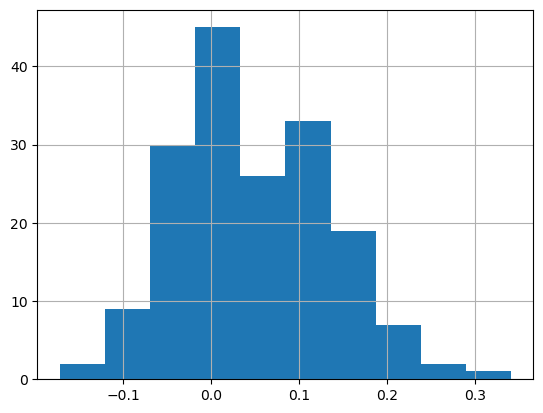

In [114]:
tmp =merged_res['Mesenchyme=Mesenchyme'].copy()
tmp = tmp.loc[tmp.index.str.split('_').str[0] != tmp.index.str.split('_').str[1]]
tmp['global_I'].hist()

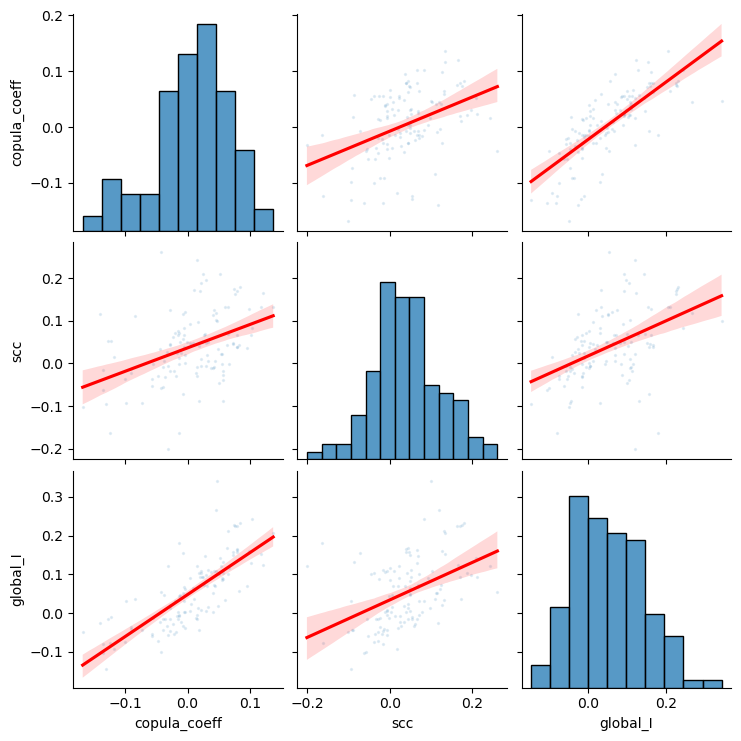

In [115]:
sns.pairplot(
    tmp.loc[tmp.copula_method == 'copula', ['copula_coeff','scc','global_I']],
    kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'s':2,
                                                                      'alpha': 0.1}}
)

In [116]:
from adjustText import adjust_text
import itertools
score_pair = list(itertools.combinations(['copula_coeff', 'scc','global_I'],2))

In [118]:
internal_edges = int_edges_subset.loc[
    int_edges_subset.boundary_type == 'Internal'].interaction.unique()
external_edges = int_edges_subset.loc[
    int_edges_subset.boundary_type == 'External'].interaction.unique()

In [120]:
merged_res['Cavity=Cavity'].loc[]

,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,global_I,global_pval,copula_coeff,mu_x,mu_y,copula_method,scc
EFNB2_EPHB4,EFNB2_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb4,0.020668,5.183218e-01,0,0,0,skip,0.007841
EFNB3_EPHA4,EFNB3_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Epha4,0.031423,3.408742e-01,0,0,0,skip,0.032402
EFNB3_EPHB1,EFNB3_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb1,0.006386,7.195349e-01,0,0,0,skip,0.005691
EFNB3_EPHB2,EFNB3_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb2,0.031642,3.405517e-01,0,0,0,skip,0.036611
EFNB3_EPHB3,EFNB3_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb3,0.004643,7.346024e-01,0,0,0,skip,-0.014181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NRG1_ERBB2_ERBB3,NRG1_ERBB2_ERBB3,NRG,NaN,NaN,NaN,NaN,KEGG: mmu04012,Secreted Signaling,Nrg1 - (Erbb2+Erbb3),0.030934,3.451697e-01,0,0,0,skip,-0.005036
MIF_ACKR3,MIF_ACKR3,MIF,NaN,NaN,NaN,NaN,PMID: 26175090,Secreted Signaling,Mif - Ackr3,0.075008,1.952619e-02,0,0,0,skip,0.048971
MIF_CD74_CD44,MIF_CD74_CD44,MIF,NaN,NaN,NaN,NaN,PMID: 29637711; PMID: 26175090,Secreted Signaling,Mif - (Cd74+Cd44),0.233252,6.287921e-17,0,0,0,skip,0.246253
CXCL12_ACKR3,CXCL12_ACKR3,CXCL,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Cxcl12 - Ackr3,-0.011763,9.185404e-01,0,0,0,skip,0.013006


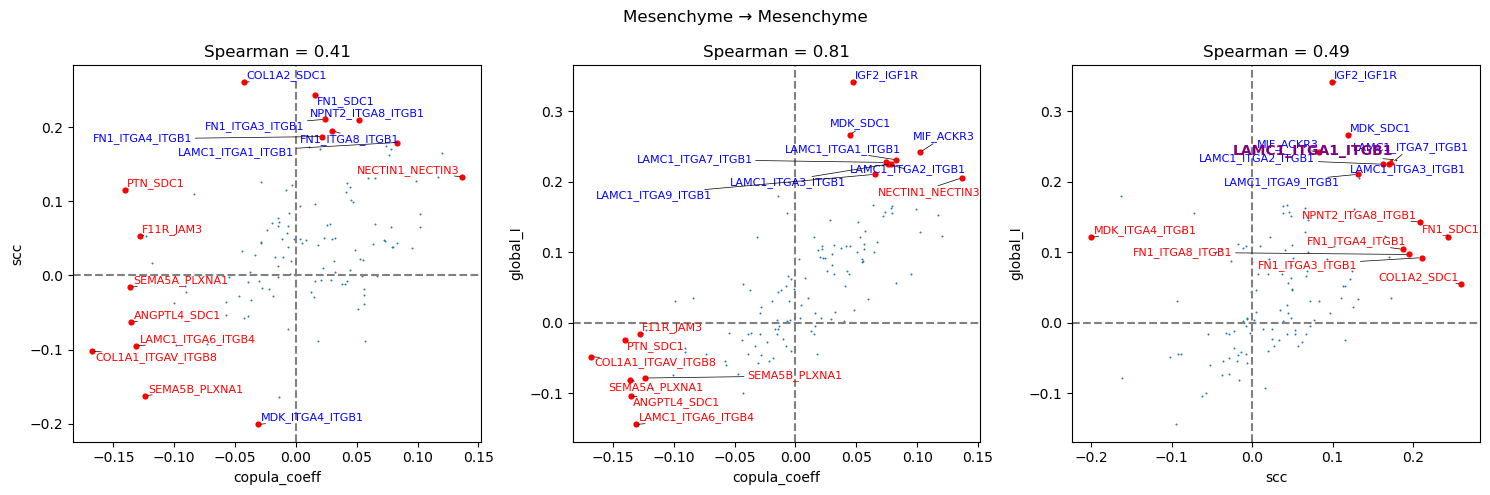

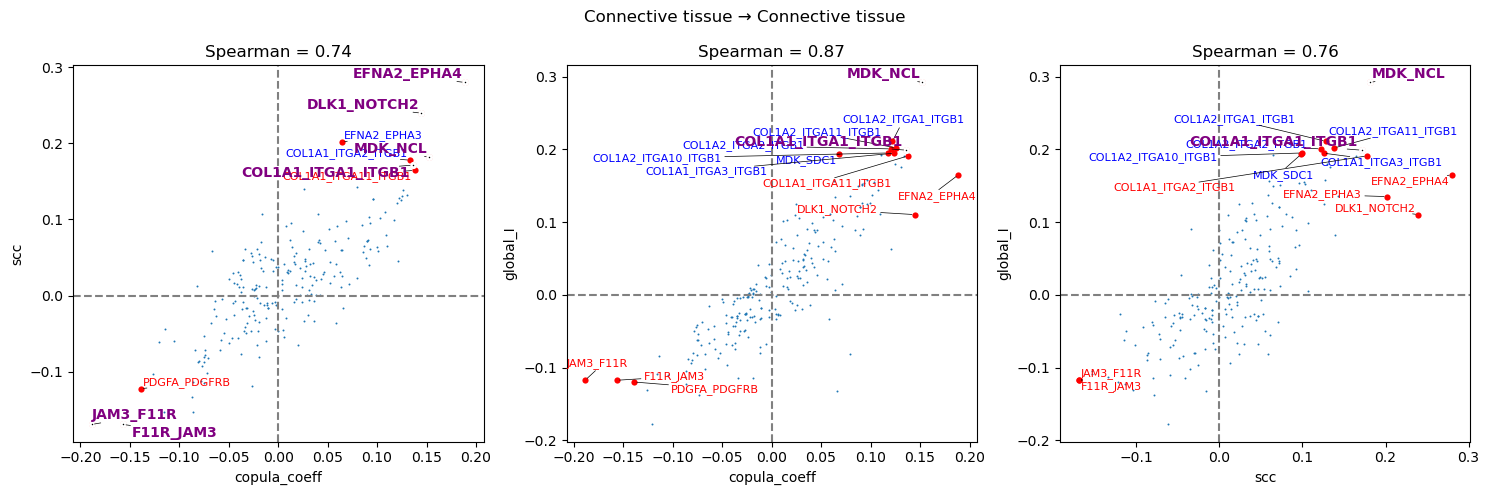

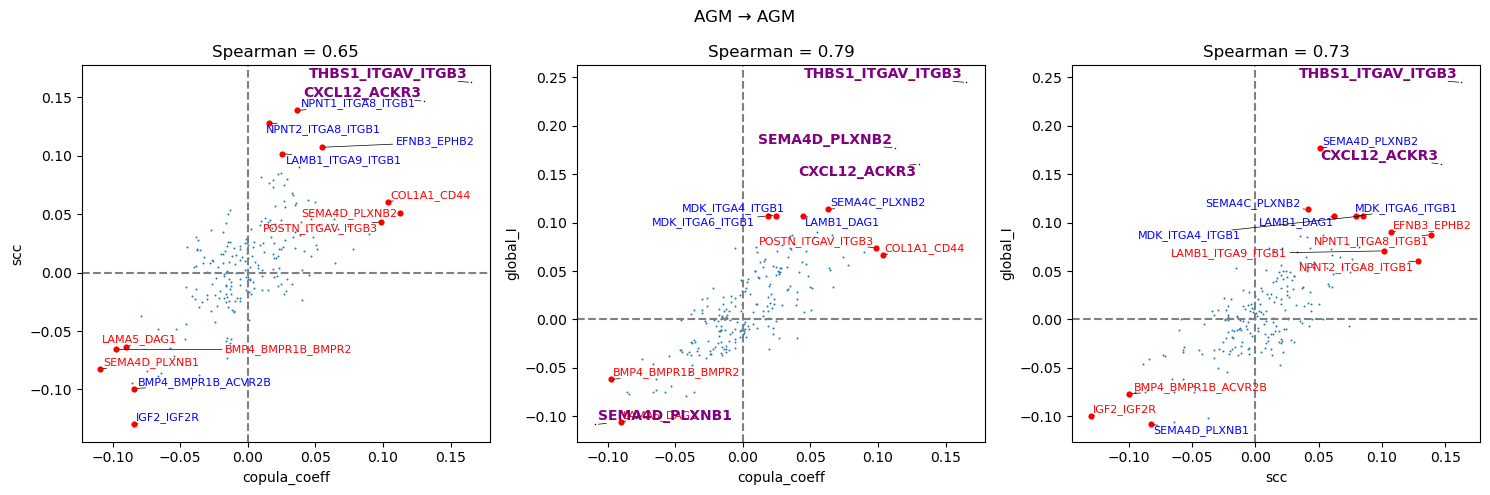

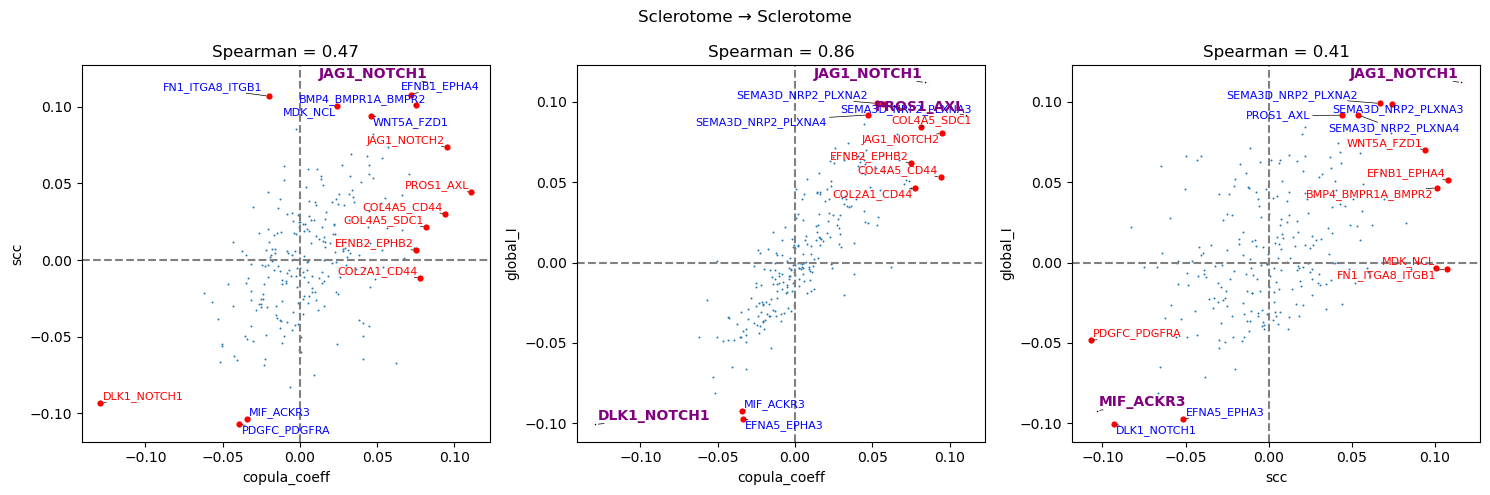

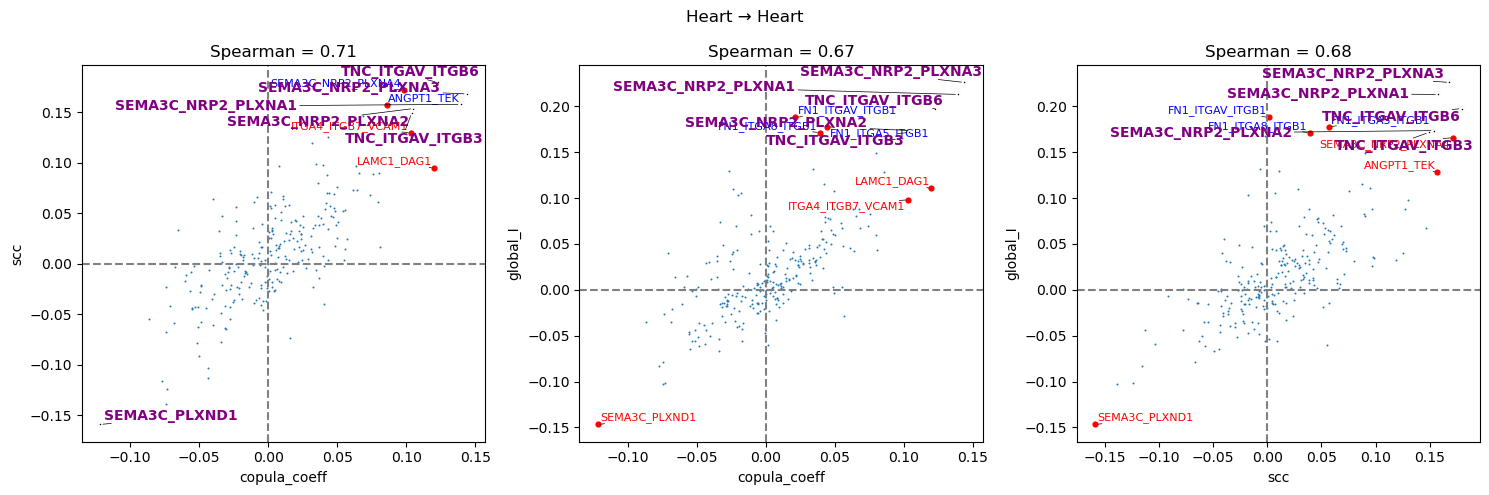

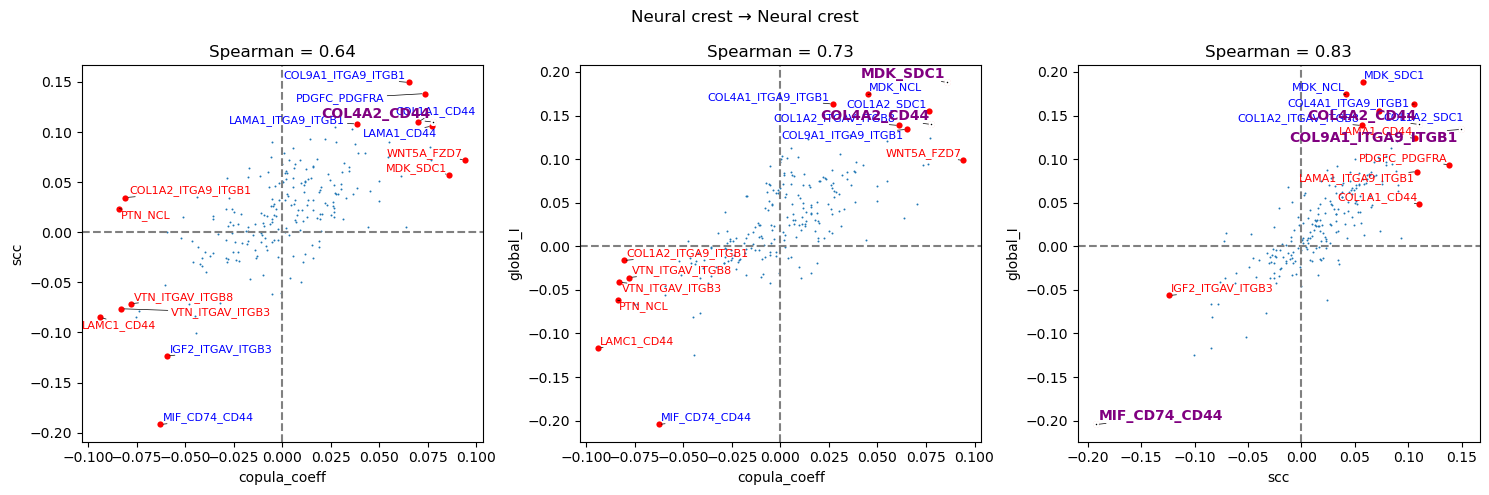

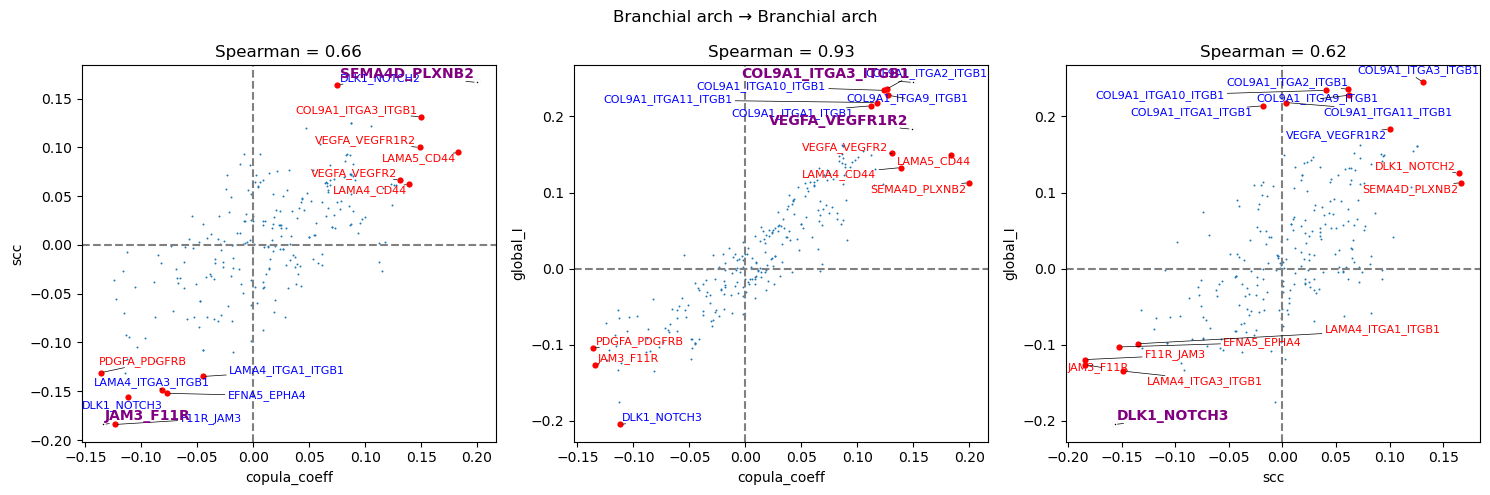

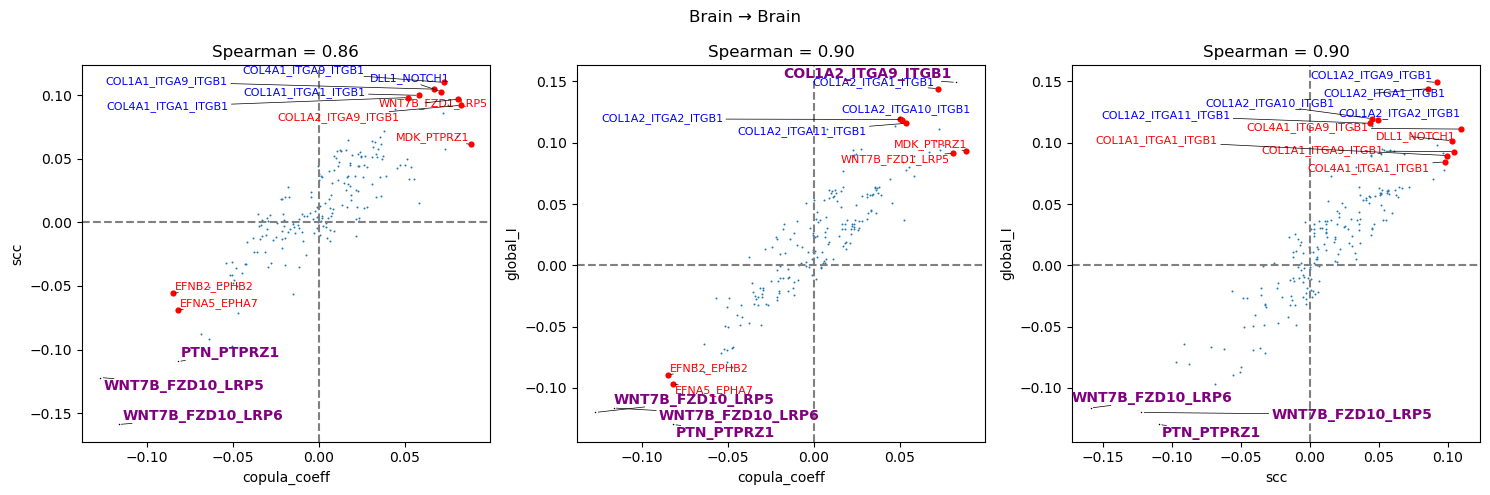

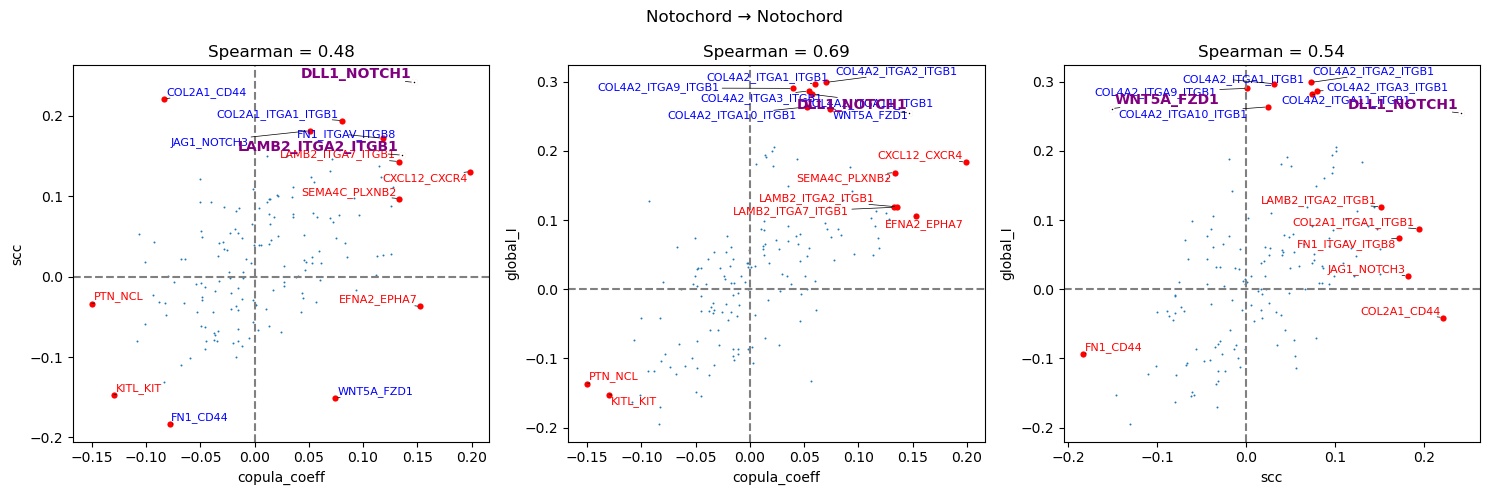

In [126]:
ntop = 8
for gpair in internal_edges:
    res = merged_res[gpair].copy()
    #res = res.drop_duplicates(['ligand', 'receptor'])
    # only take non sparse entries
    
    res = res.loc[res.copula_method == 'copula'].fillna(0)
    res = res.loc[res.index.str.split('_').str[0] != res.index.str.split('_').str[1]]
    if res.shape[0] < 5:
        continue
    ncol = len(score_pair)
    _, ax = plt.subplots(1,ncol, figsize=(5*ncol,5))
    for i,(x_col, y_col) in enumerate(score_pair):
        
        sig1 = res.sort_values(by=x_col, key=lambda x: abs(x), ascending=False)[:ntop]
        sig2 = res.sort_values(by=y_col, key=lambda x: abs(x), ascending=False)[:ntop]

        sig12 = sig1.join(sig2, rsuffix='_2',how='inner')
        
        sns.scatterplot(data = res, 
                        x = x_col, 
                        y = y_col, s = 2, linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig1, 
                x = x_col, 
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig2, 
                x = x_col,
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])

        text_sig = []
        for j,r in sig1.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(1, 0, 0),
                                        fontsize = 8
                                    ))
        
        for j,r in sig2.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(0, 0, 1),
                                        fontsize = 8
                                    ))
        
        if(len(text_sig) > 0):
            adjust_text(text_sig,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        
        if (len(sig12) > 0):
            sns.scatterplot(data = sig12, 
                                x = x_col, y = y_col, s = 10, c='black', linewidth = 2,
                                ax = ax[i])
            text_sig12 = []
            for j,r in sig12.iterrows():
                text_sig12.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                            s = j,
                                            color = (0.5, 0, 0.5),
                                            fontsize = 10,
                                            weight='bold'
                                        ))
            adjust_text(text_sig12,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        ax[i].set_title(f'Spearman = { stats.spearmanr(res[x_col].values, res[y_col].values)[0] :.2f}')
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].axvline(0, color='grey', linestyle='--')
        
    
    plt.suptitle(gpair.replace('=',' → '))
    plt.tight_layout()
    plt.show()

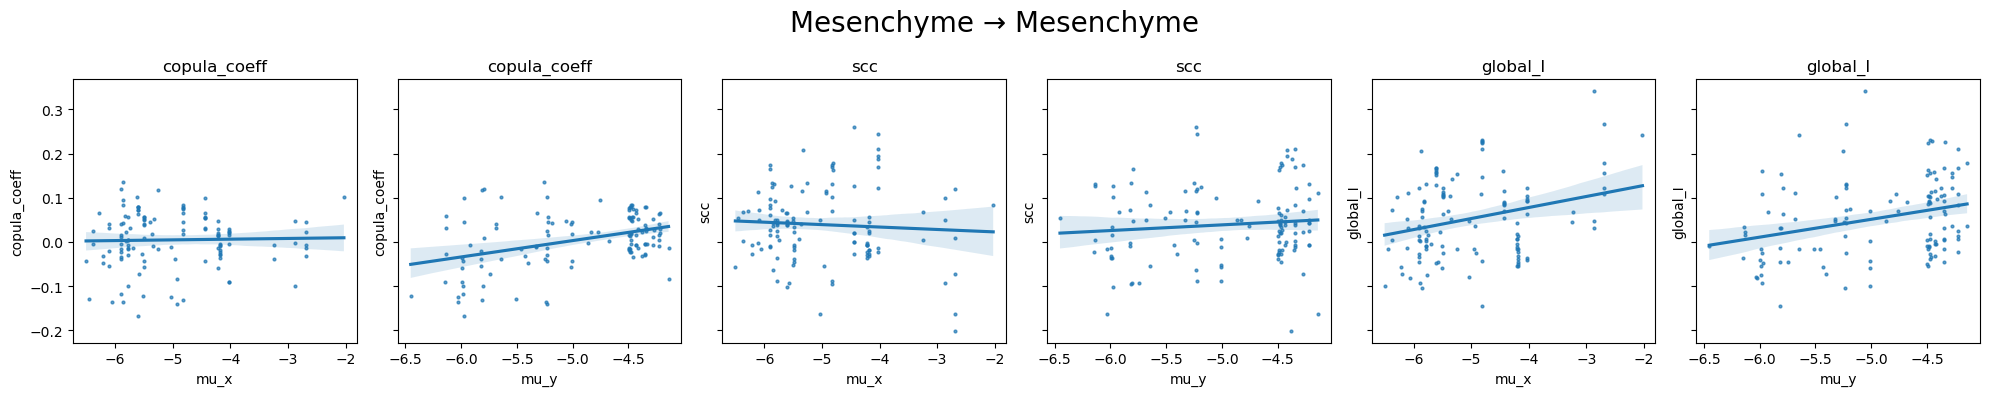

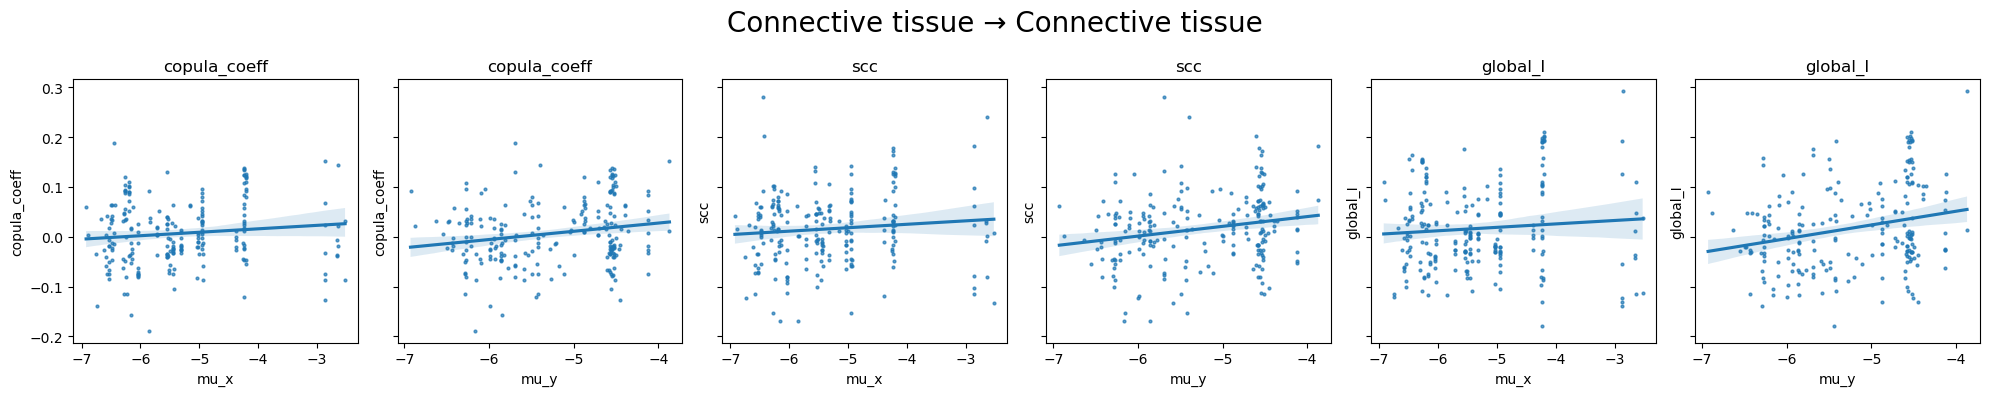

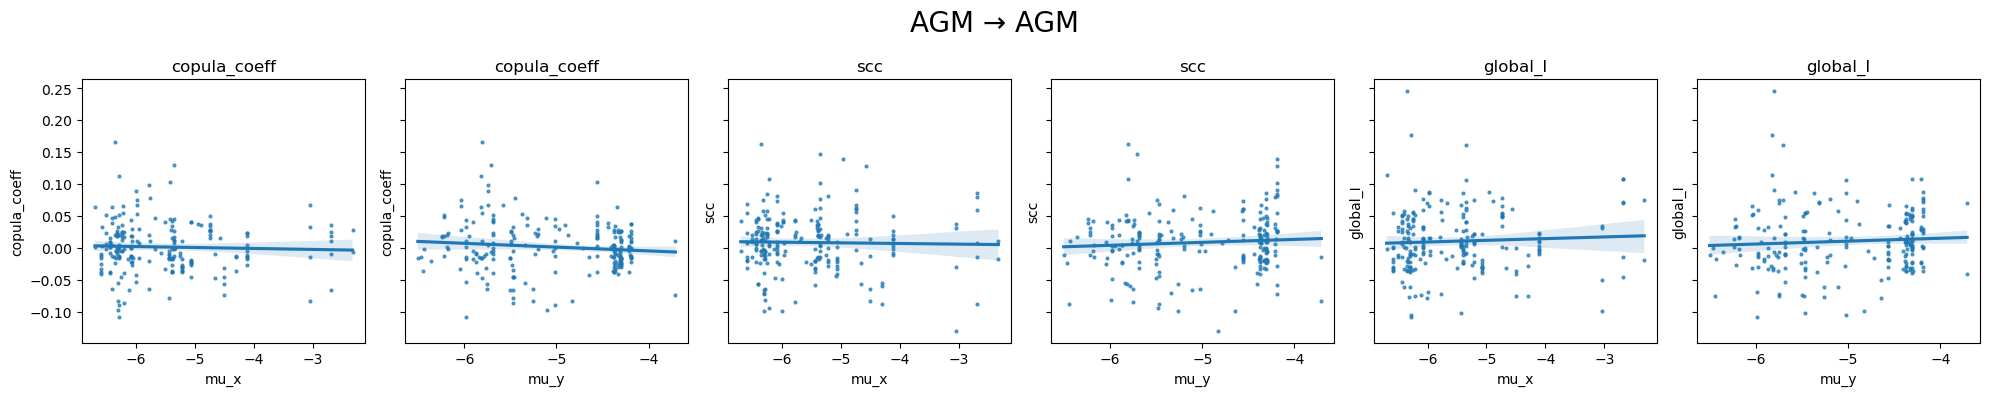

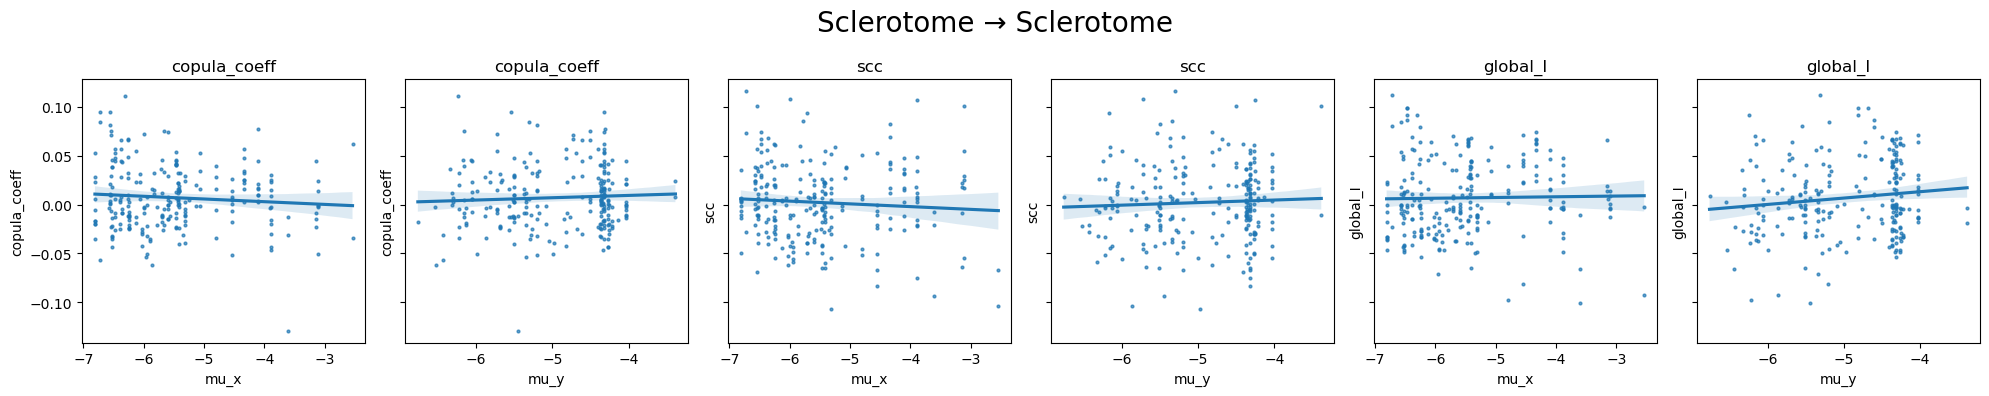

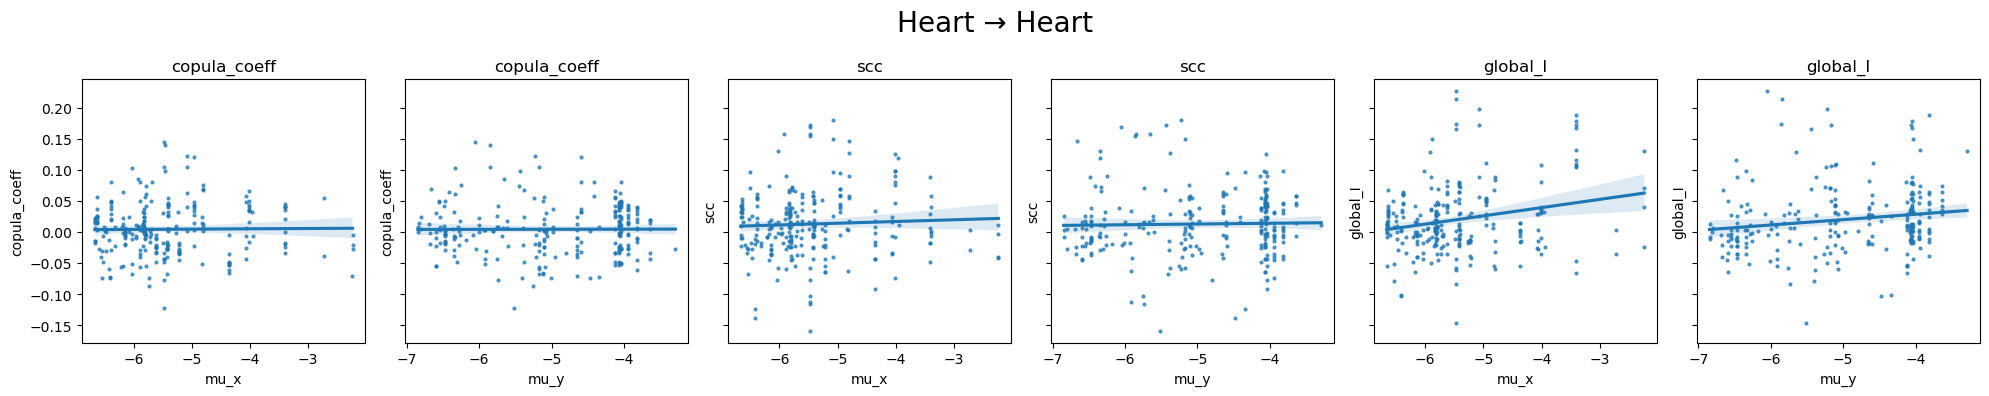

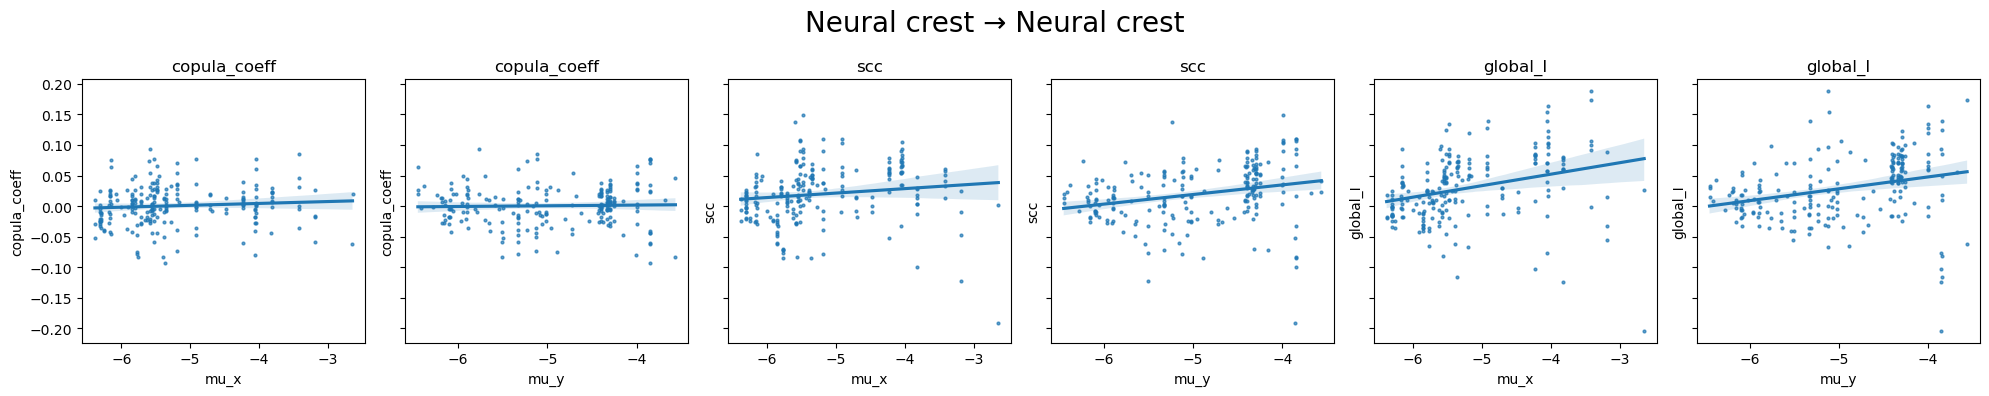

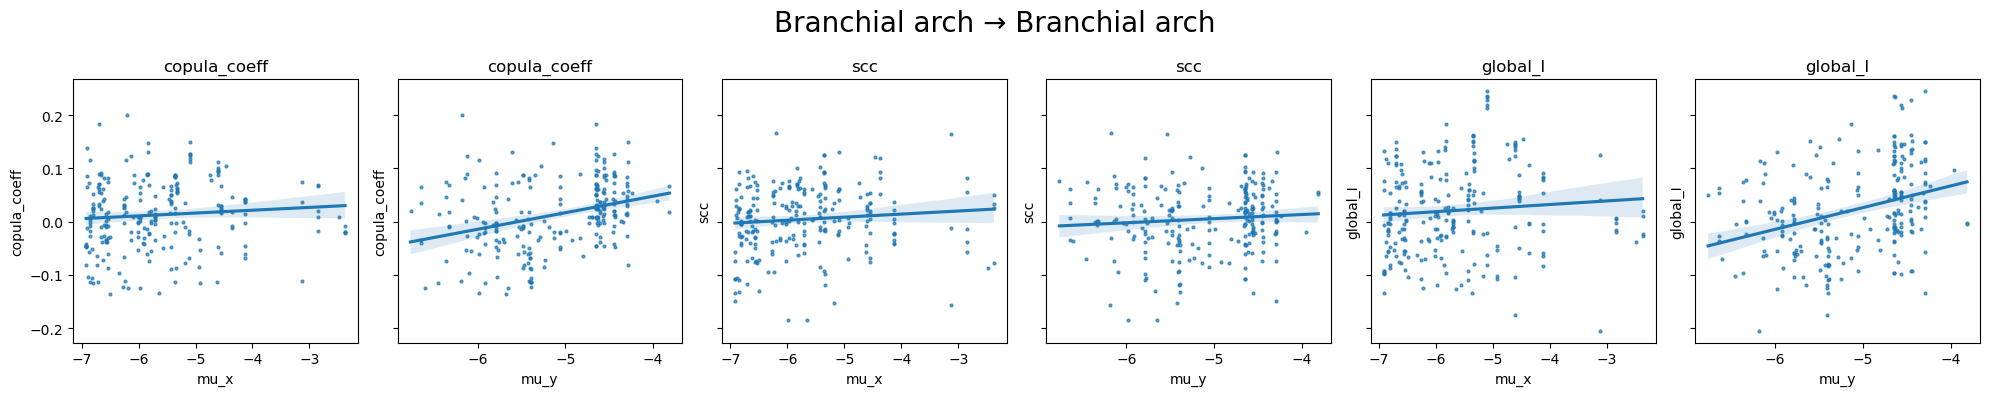

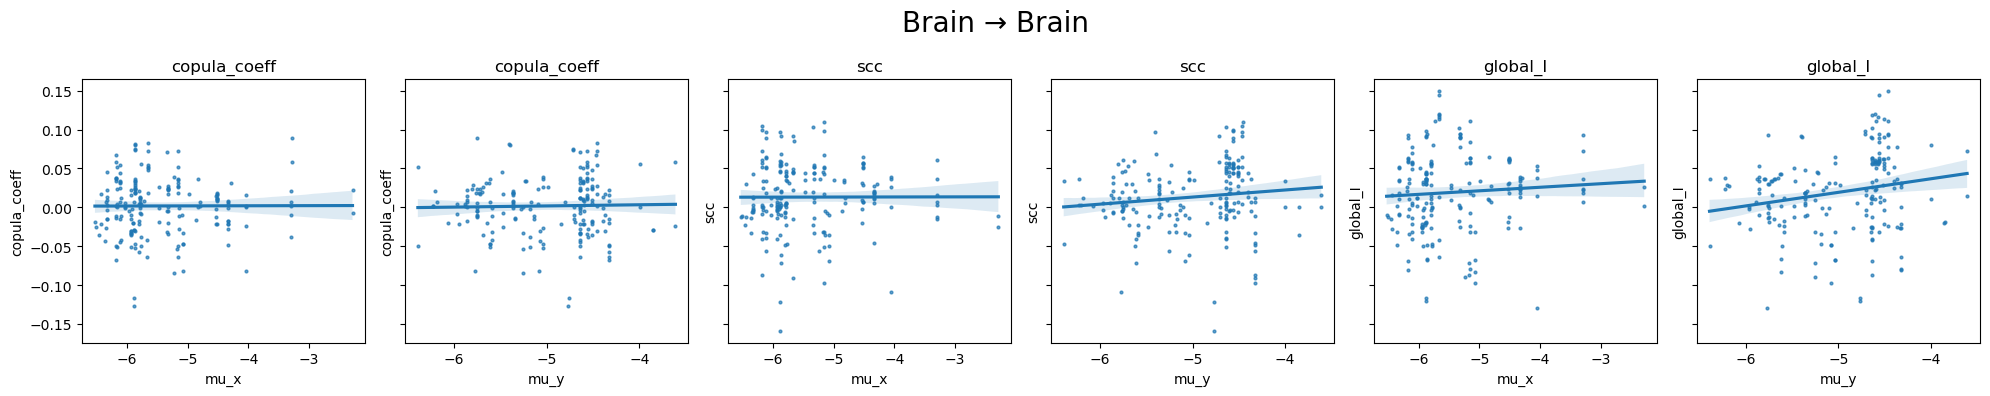

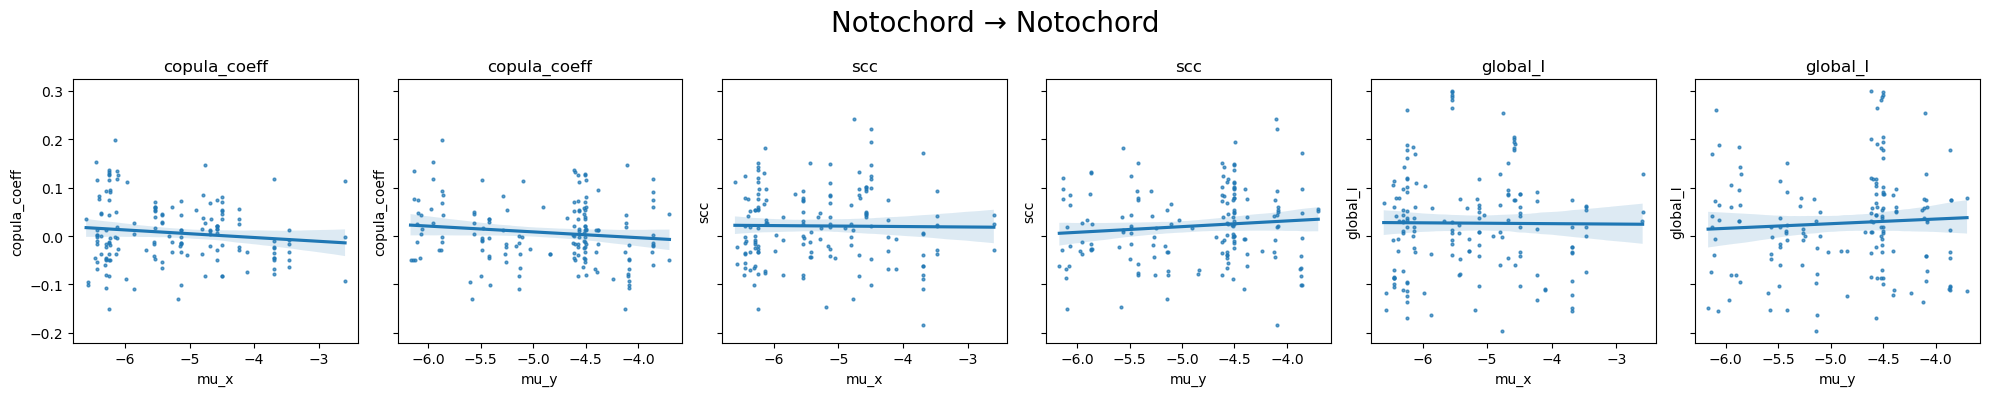

In [125]:
for j, gpair in enumerate(internal_edges):
    g11,g12 = gpair.split('=')
    row_idx = 0
    #ax = axes[j,:]
    
    tmp = merged_res[gpair].copy()
    tmp = tmp.loc[tmp.copula_method == 'copula']
    if tmp.shape[0] < 10:
        continue
    _, ax = plt.subplots(1, 6, figsize=(20,4),sharey = True)
    tmp = tmp.loc[tmp.index.str.split('_').str[0] != tmp.index.str.split('_').str[1]]
    
    mu_x = tmp['mu_x']
    mu_y = tmp['mu_y']
    min_val = min(mu_x.min(), mu_y.min()) - 0.2
    max_val = max(mu_x.max(), mu_y.max()) + 0.2
    

    abline = np.linspace(min_val, max_val, 100)
    for i,ycol in enumerate(['copula_coeff', 'scc', 'global_I']): 
        
        sns.regplot(x='mu_x', y=ycol, data=tmp,scatter_kws={'alpha':0.7,'s':4},ax= ax[2*i])
        sns.regplot(x='mu_y', y=ycol, data=tmp,scatter_kws={'alpha':0.7,'s':4},ax= ax[2*i+1])
        
        
        # Remove the legend and add a colorba
        ax[2*i].set_title(ycol)
        ax[2*i+1].set_title(ycol)
        
    plt.suptitle(gpair.replace('=',' → '),fontsize=20)
    plt.tight_layout()
plt.show()

## Read the pvalues

In [127]:
data_dir = '/Users/hs0424/Workspace/copulacci/notebook/orator_paper_notebook/data/mosta_mouse_embryo/pvals_90/'

In [128]:
import glob

In [135]:
gpairs_selected = [g.split('/')[-1].replace('final_res_copula_','').replace('.csv','') for g in glob.glob(data_dir + '/*.csv')]

In [136]:
import os
dfs = []
for gpair in gpairs_selected:
    file_name = 'final_res_copula_' + gpair + '.csv'
    tmp = pd.read_csv(
        os.path.join(data_dir, file_name),
    )
    tmp.loc[:, 'gpair'] = gpair
    dfs += [tmp.copy()]

In [137]:
cop_sig_df = pd.concat(dfs, axis=0)

In [138]:
cop_sig_df['source'] = cop_sig_df.celltype_direction.str.split("=").str[0]
cop_sig_df['target'] = cop_sig_df.celltype_direction.str.split("=").str[1]

In [140]:
cop_sig_df

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target
0,0.107975,-6.381838,-4.297870,copula,CDH1_ITGA1_ITGB1,0.019960,0.033932,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
1,0.088645,-6.176819,-4.142405,copula,LAMA1_ITGA9_ITGB1,0.065868,0.069985,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
2,0.129700,-6.552809,-4.146649,copula,LAMB2_ITGA9_ITGB1,0.003992,0.022621,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
3,0.088062,-6.176632,-4.304586,copula,LAMA1_ITGA7_ITGB1,0.035928,0.046983,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
4,0.114667,-6.552159,-4.308687,copula,LAMB2_ITGA7_ITGB1,0.013972,0.033932,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
...,...,...,...,...,...,...,...,...,...,...,...
14,0.117977,-3.691880,-3.855137,copula,FN1_ITGAV_ITGB8,0.101796,0.161178,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
15,0.092031,-6.235749,-3.860833,copula,LAMB2_ITGAV_ITGB8,0.137725,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
16,0.116070,-6.441894,-5.487313,copula,COL1A2_SDC1,0.137725,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
17,0.113098,-2.592456,-5.101146,copula,MIF_ACKR3,0.149701,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord


In [141]:
cop_sig_df.loc[:,'celltype_arrow'] = cop_sig_df.celltype_direction.str.replace("="," → ")

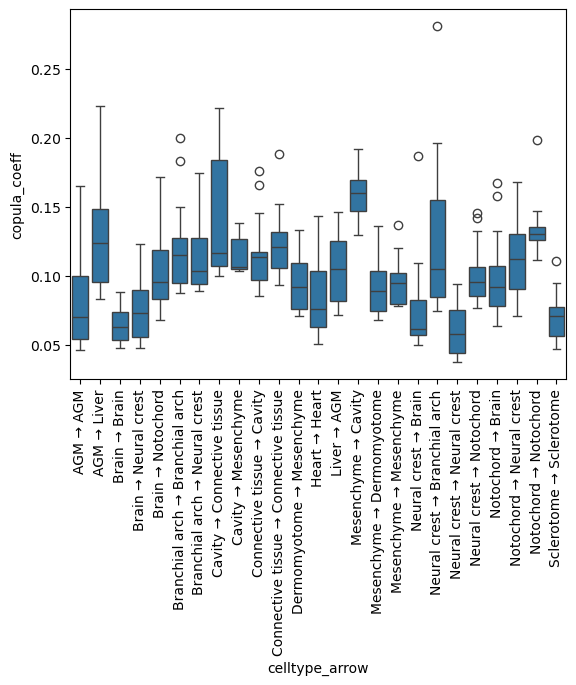

In [142]:
qval_cutoff = 0.1
ax = sns.boxplot(
    data = cop_sig_df.loc[cop_sig_df.qval < qval_cutoff].sort_values(['gpair']),
    x = 'celltype_arrow',
    y = 'copula_coeff'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

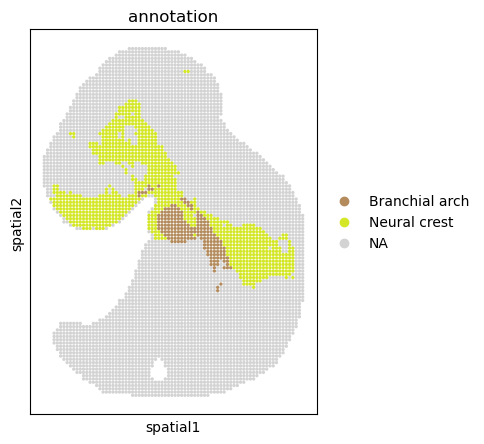

In [144]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], groups = ['Neural crest', 'Branchial arch'],
              spot_size=1, ax =ax)

In [145]:
ct = 'Neural crest'
cop_sig_df_tumor = cop_sig_df.loc[
    ((cop_sig_df.source == ct) | (cop_sig_df.target == ct))
].copy()

In [146]:
cop_sig_df_tumor.sort_values(['qval','copula_coeff'],
                             ascending=[True, False]).groupby('celltype_direction').head(3).sort_values(['gpair'])

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target,celltype_arrow
18,0.112353,-3.277021,-3.597465,copula,MDK_NCL,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
11,0.104988,-5.893318,-3.921500,copula,LAMA4_CD44,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
20,0.123013,-4.696803,-3.594546,copula,PTN_NCL,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
20,0.101246,-2.707014,-5.375586,copula,IGF2_ITGAV_ITGB3,0.000000,0.000000,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
3,0.140490,-6.195033,-4.391134,copula,VTN_ITGA8_ITGB1,0.000000,0.000000,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
17,0.174526,-6.129745,-6.067165,copula,SEMA3C_PLXND1,0.005988,0.021956,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
21,0.109590,-3.588395,-5.937869,copula,MDK_PTPRZ1,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
22,0.186837,-6.372803,-5.899221,copula,PDGFC_PDGFRA,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
15,0.089861,-5.535872,-4.089527,copula,LAMA1_CD44,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
5,0.176169,-6.031437,-5.810682,copula,JAG2_NOTCH2,0.000000,0.000000,Neural crest=Branchial arch,Neural crest=Branchial arch,Neural crest,Branchial arch,Neural crest → Branchial arch


In [185]:
sdm_df_dict[int_type].loc[
    sdm_df_dict[int_type].pathway_name == 'EPHB']

,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,global_I,global_pval
EFNB2_EPHB4,EFNB2_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb4,-0.019963,1.000000e+00
EFNB3_EPHA4,EFNB3_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Epha4,-0.025448,1.000000e+00
EFNB3_EPHB1,EFNB3_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb1,-0.026133,1.000000e+00
EFNB3_EPHB2,EFNB3_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb2,0.033659,3.494873e-44
EFNB3_EPHB3,EFNB3_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb3,-0.012981,1.000000e+00
EFNB3_EPHB4,EFNB3_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb4,0.010076,2.942267e-05
EFNB2_EPHB3,EFNB2_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb3,0.019489,7.674826e-16
EFNB2_EPHB2,EFNB2_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb2,0.047433,4.343888e-86
EFNB2_EPHB1,EFNB2_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb1,-0.004805,1.000000e+00
EFNB2_EPHA4,EFNB2_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Epha4,0.044347,1.817188e-75


In [184]:
sdm_df_dict[int_type]

,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,global_I,global_pval
EFNB2_EPHB4,EFNB2_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb4,-0.019963,1.000000e+00
EFNB3_EPHA4,EFNB3_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Epha4,-0.025448,1.000000e+00
EFNB3_EPHB1,EFNB3_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb1,-0.026133,1.000000e+00
EFNB3_EPHB2,EFNB3_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb2,0.033659,3.494873e-44
EFNB3_EPHB3,EFNB3_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb3,-0.012981,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
MIF_CD74_CXCR4,MIF_CD74_CXCR4,MIF,NaN,NaN,NaN,NaN,PMID: 29637711; PMID: 24760155,Secreted Signaling,Mif - (Cd74+Cxcr4),-0.018455,1.000000e+00
CXCL12_ACKR3,CXCL12_ACKR3,CXCL,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Cxcl12 - Ackr3,0.032978,1.709030e-42
CXCL12_CXCR4,CXCL12_CXCR4,CXCL,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Cxcl12 - Cxcr4,0.049282,8.868466e-93
CTF1_LIFR_IL6ST,CTF1_LIFR_IL6ST,LIFR,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Ctf1 - (Lifr+Il6st),-0.000210,9.183946e-01


In [174]:
cop_sig_df_tumor.loc[cop_sig_df_tumor.lig_rec == 'EFNB1_EPHB2']

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target,celltype_arrow
3,0.196263,-5.93136,-6.433729,copula,EFNB1_EPHB2,0.0,1.192093e-07,Neural crest=Branchial arch,Neural crest=Branchial arch,Neural crest,Branchial arch,Neural crest → Branchial arch


In [175]:
cop_sig_df_tumor.qval = cop_sig_df_tumor.qval + EPSILON
cop_sig_df_tumor.pval = cop_sig_df_tumor.pval + EPSILON

In [176]:
import gseapy_like_plot as pl

p_inv


<Axes: xlabel='celltype_direction'>

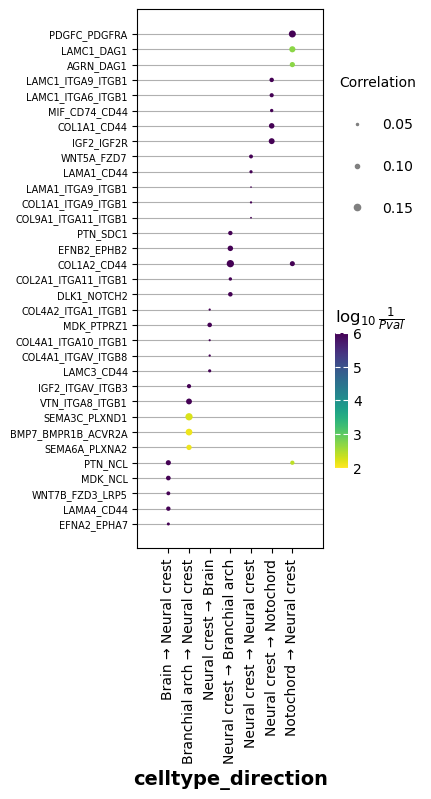

In [179]:
pl.dotplot(
    cop_sig_df_tumor,
    columns = 'qval',
    x = 'celltype_direction',
    y = 'lig_rec',
    xlabelsize=10,
    ylabelsize=7,
    figsize=(3,7),
    xticklabels_rot=90,
    show_ligrec_dir=False,
    top_term=5,
    cutoff=0.01,
    size=5,
)

In [155]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names
loc_df.set_index('cell', inplace=True)

In [162]:

from matplotlib.colors import Normalize
def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
):
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    genes_to_show = [gene.capitalize() for gene in lig_rec_idx.split("_")]
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5))
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=10, data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        ax[i].set_xlabel("spatial1")
        ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    plt.show()





In [187]:
sdm_df_dict[int_type].loc[
    sdm_df_dict[int_type].pathway_name == 'EPHB'].global_I

EFNB2_EPHB4   -0.019963
EFNB3_EPHA4   -0.025448
EFNB3_EPHB1   -0.026133
EFNB3_EPHB2    0.033659
EFNB3_EPHB3   -0.012981
EFNB3_EPHB4    0.010076
EFNB2_EPHB3    0.019489
EFNB2_EPHB2    0.047433
EFNB2_EPHB1   -0.004805
EFNB2_EPHA4    0.044347
EFNB1_EPHA4    0.036231
EFNB1_EPHB1    0.177448
EFNB1_EPHB2    0.036233
EFNB1_EPHB3    0.004274
EFNB1_EPHB4   -0.010651
Name: global_I, dtype: float64

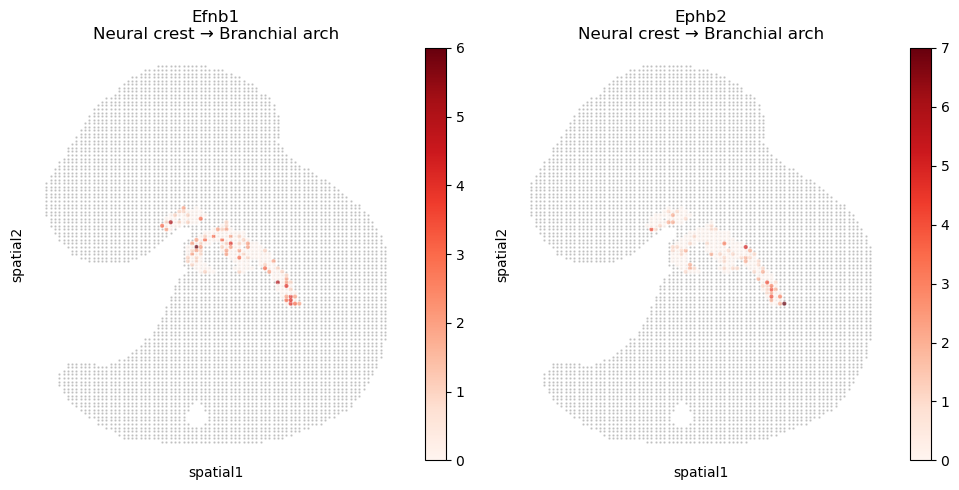

In [192]:
lig_rec_idx = 'EFNB1_EPHB2'
int_type = 'Neural crest=Branchial arch'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
)

In [191]:
cop_df_dict[int_type].loc['EFNB1_EPHB1']

copula_coeff          0.0
mu_x                  0.0
mu_y                  0.0
copula_method        skip
scc              0.030477
Name: EFNB1_EPHB1, dtype: object

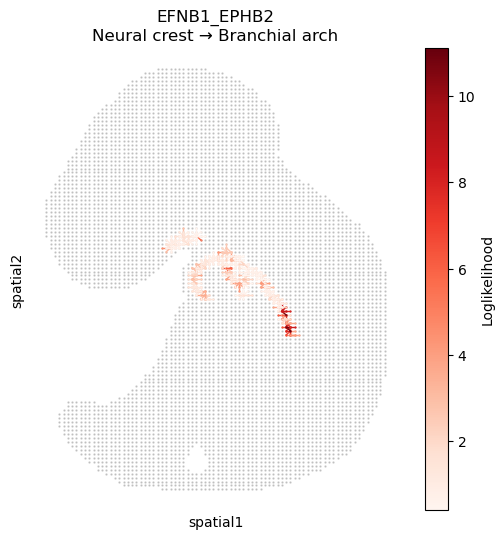

In [193]:
plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict
)

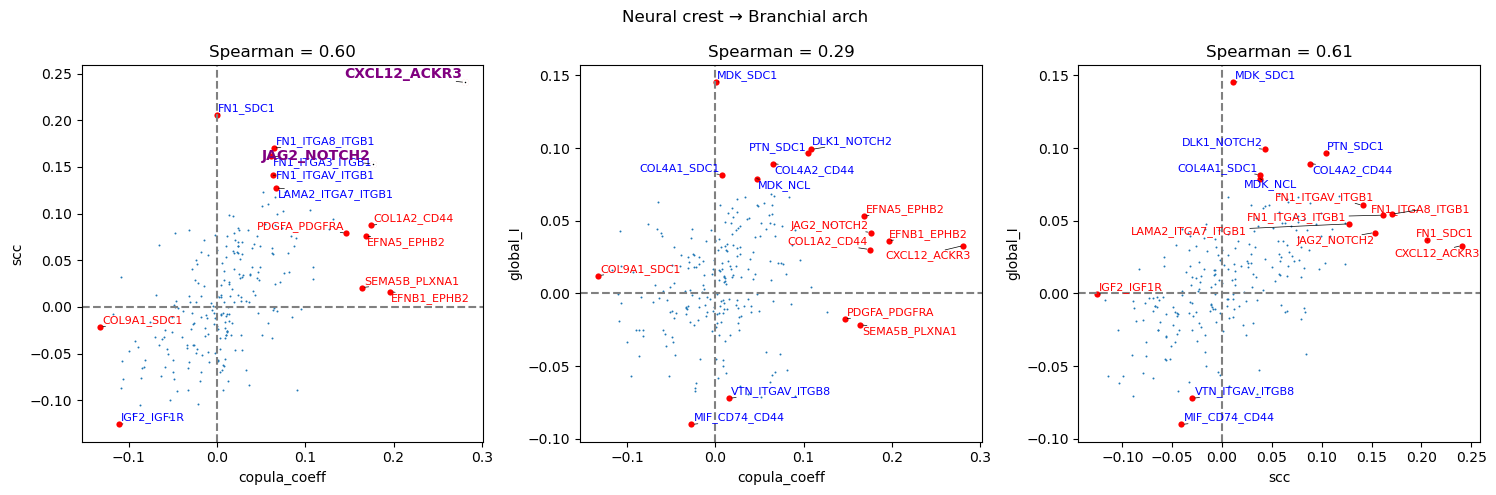

In [167]:
ntop = 8
for gpair in [int_type]:
    res = merged_res[gpair].copy()
    #res = res.drop_duplicates(['ligand', 'receptor'])
    # only take non sparse entries
    
    res = res.loc[res.copula_method == 'copula'].fillna(0)
    res = res.loc[res.index.str.split('_').str[0] != res.index.str.split('_').str[1]]
    if res.shape[0] < 5:
        continue
    ncol = len(score_pair)
    _, ax = plt.subplots(1,ncol, figsize=(5*ncol,5))
    for i,(x_col, y_col) in enumerate(score_pair):
        
        sig1 = res.sort_values(by=x_col, key=lambda x: abs(x), ascending=False)[:ntop]
        sig2 = res.sort_values(by=y_col, key=lambda x: abs(x), ascending=False)[:ntop]

        sig12 = sig1.join(sig2, rsuffix='_2',how='inner')
        
        sns.scatterplot(data = res, 
                        x = x_col, 
                        y = y_col, s = 2, linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig1, 
                x = x_col, 
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig2, 
                x = x_col,
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])

        text_sig = []
        for j,r in sig1.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(1, 0, 0),
                                        fontsize = 8
                                    ))
        
        for j,r in sig2.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(0, 0, 1),
                                        fontsize = 8
                                    ))
        
        if(len(text_sig) > 0):
            adjust_text(text_sig,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        
        if (len(sig12) > 0):
            sns.scatterplot(data = sig12, 
                                x = x_col, y = y_col, s = 10, c='black', linewidth = 2,
                                ax = ax[i])
            text_sig12 = []
            for j,r in sig12.iterrows():
                text_sig12.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                            s = j,
                                            color = (0.5, 0, 0.5),
                                            fontsize = 10,
                                            weight='bold'
                                        ))
            adjust_text(text_sig12,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        ax[i].set_title(f'Spearman = { stats.spearmanr(res[x_col].values, res[y_col].values)[0] :.2f}')
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].axvline(0, color='grey', linestyle='--')
        
    
    plt.suptitle(gpair.replace('=',' → '))
    plt.tight_layout()
    plt.show()